In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#export
from collections import defaultdict

import numpy as np
import pandas as pd

from loop.callbacks import Callback, Order
from loop.utils import calculate_layout

In [3]:
from functools import partial
import matplotlib.pyplot as plt

In [4]:
N = 1000

In [5]:
def plot(sched):
    xs = list(range(N))
    ys = [sched(x) for x in xs]
    f, ax = plt.subplots(1, 1)
    ax.plot(xs, ys)
    return ax

In [6]:
#export
class CosineAnnealing:
    """A schedule that returns eta multiplier in range from 0.0 to 1.0."""
    
    def __init__(self, t_max, minmax=(0.0, 1.0), mult=2):
        self.t_max = t_max
        self.minmax = minmax
        self.mult = mult
        self.iter = 0
        
    def __call__(self, t):
        self.iter += 1
        (lo, hi), n = self.minmax, self.t_max
        x = self.iter % n
        eta = lo + (hi - lo)*(1 + np.cos(np.pi*x/n))/2
        if x == 0:
            self.iter = 0
            self.t_max *= self.mult
        return eta

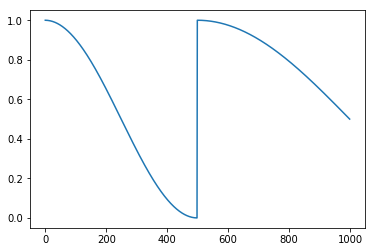

In [7]:
plot(CosineAnnealing(t_max=N/2));

In [8]:
#export
def linear(epoch, t_max, minmax=(1e-7, 1)):
    """Simple linear schedule in minmax range."""
    lo, hi = minmax
    k = (hi - lo)/(t_max - 1)
    return k*epoch + lo


def cosine(epoch, t_max, ampl=1.0):
    """Shifted and scaled cosine function."""
    t = epoch % t_max
    return (1 + np.cos(np.pi*t/t_max))*ampl/2


def inv_cosine(epoch, t_max, ampl=0.6):
    """A cosine function reflected on X-axis."""
    return 1 - cosine(epoch, t_max, ampl)


def one_cycle(epoch, t_max, f1=inv_cosine, f2=cosine, pivot=0.3):
    """A combined schedule with two cosine half-waves."""
    pct = epoch / t_max
    if pct < pivot:
        return f1(epoch, pivot*t_max)
    return f2(epoch - pivot*t_max, (1-pivot)*t_max)

In [9]:
#export 
class Function:
    def __init__(self, func, **params):
        self.func = func
        self.params = params
    def __call__(self, t):
        return self.func(t, **self.params)

In [10]:
#export
OneCycle = lambda **params: Function(one_cycle, **params)

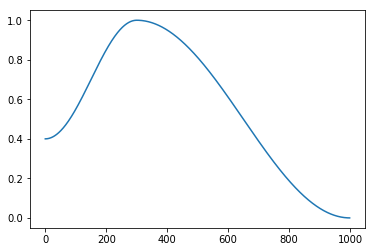

In [11]:
plot(OneCycle(t_max=N, pivot=0.3));

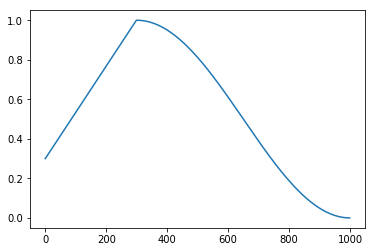

In [12]:
plot(OneCycle(t_max=N, f1=partial(linear, minmax=(0.3, 1.0))));

In [13]:
#export
class Scheduler(Callback):
    """Updates optimizer's learning rates using provided scheduling function."""
    
    order = Order.Schedule()
    
    def __init__(self, opt, schedule: 'callable', params: list=None, mode: str='batch'):
        assert mode in {'batch', 'epoch'}
        params = _make_sched_params(params)
        self.opt = opt
        self.schedule = schedule
        self.params = params
        self.n_steps = 0
        
    def training_started(self, **kwargs):
        self.history = defaultdict(list)
        
    def epoch_started(self, epoch, **kwargs):
        if self.mode == 'epoch': 
            self.step(epoch)
    
    def batch_started(self, phase, **kwargs):
        if self.mode == 'batch': 
            if phase.grad:
                self.step(phase.batch_index)
        
    def step(self, t):
        self.n_steps += 1
        mult = self.schedule(t)
        for i, group in enumerate(self.opt.param_groups):
            for item in self.params:
                name = item['name']
                if name not in group:
                    continue
                start = opt.defaults[name]
                inv = item.get('inverse', False)
                d = (1 - mult) if inv else mult
                absolute = item.get('absolute', False)
                new_value = d if absolute else start * d
                group[name] = new_value
                self.history[name].append(new_value)
                
    def plot(self, params=None, axes=None):
        params = params or ['lr']
        records = {'iteration': list(range(self.n_steps))}
        for conf in self.params:
            name = conf['name']
            if name in params:
                records[name] = self.history[name]
        df = pd.DataFrame(records)
        if axes is None:
            n = len(params)
            f, axes = plt.subplots(*calculate_layout(n))
        for i, param in enumerate(params):
            df.plot(x='iteration', y=param, ax=axes.flat[i])
        f.tight_layout()
        return axes

In [14]:
#export
def _make_sched_params(params):
    if params is None:
        return [{'name': 'lr'}]
    converted = []
    for item in params:
        if isinstance(item, str):
            converted.append({'name': item})
        elif isinstance(item, dict):
            converted.append(item)
        else:
            raise TypeError(f'unexpected param type: {item}')
    return converted

In [15]:
tests = [
    ([{'name': 'lr'}], [{'name': 'lr'}]),
    (['lr', 'weight_decay'], [{'name': 'lr'}, {'name': 'weight_decay'}]),
    (['lr', {'name': 'weight_decay'}], [{'name': 'lr'}, {'name': 'weight_decay'}])
]
for param, result in tests:
    assert _make_sched_params(param) == result

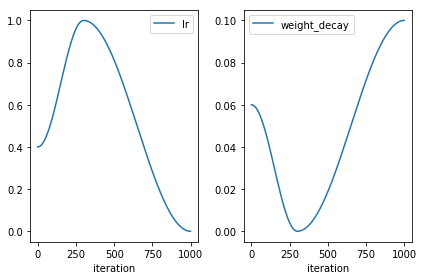

In [16]:
from torch import optim
from loop.modules import TinyNet

opt = optim.Adam(TinyNet().parameters(), lr=1.0, weight_decay=0.1)

params = [
    {'name': 'lr'},
    {'name': 'weight_decay', 'inverse': True}
]

sched = Scheduler(opt, OneCycle(t_max=N, pivot=0.3), params)
sched.training_started()

for i in range(N):
    sched.step(i)
    
sched.plot(['lr', 'weight_decay']);